In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.datasets import mnist
from tensorflow.keras import regularizers
import seaborn as sns

In [7]:
# Load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize pixel values between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [8]:
# Add random noise to the images
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip values to be in the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


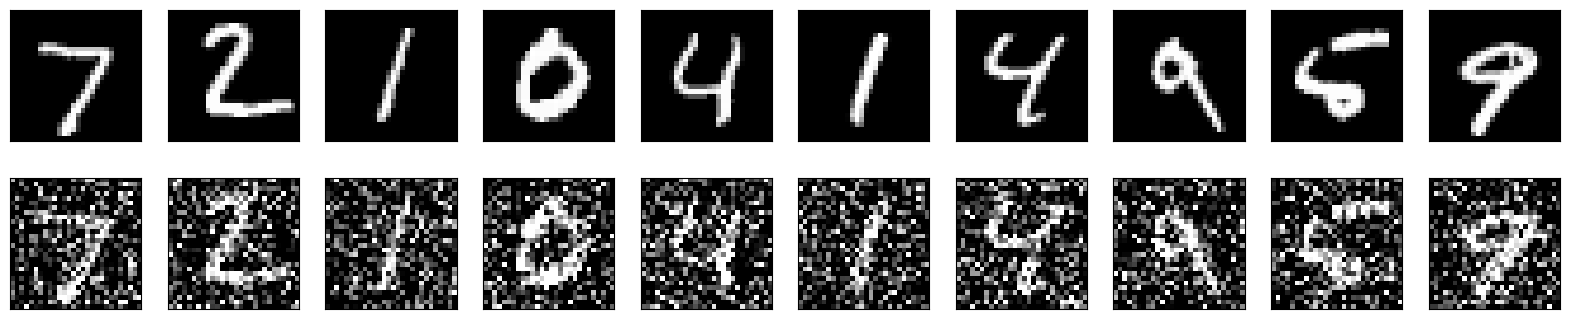

In [9]:
# Display original and noisy images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax1 = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
plt.show()


In [10]:
# Build the autoencoder model
input_img = Input(shape=(784,))
encoder = Dense(128, activation='tanh', activity_regularizer=regularizers.l1(10e-5))(input_img)
encoder = Dense(128, activation='relu')(encoder)
decoder = Dense(784, activation='tanh')(encoder)
decoder = Dense(784, activation='relu')(decoder)

autoencoder = Model(inputs=input_img, outputs=decoder)
autoencoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_8 (Dense)             (None, 128)               100480    
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 dense_10 (Dense)            (None, 784)               101136    
                                                                 
 dense_11 (Dense)            (None, 784)               615440    
                                                                 
Total params: 833568 (3.18 MB)
Trainable params: 833568 (3.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
# x_train_noisy and x_test_noisy are 28x28 images
x_train_noisy_flat = x_train_noisy.reshape((len(x_train_noisy), np.prod(x_train_noisy.shape[1:])))
x_test_noisy_flat = x_test_noisy.reshape((len(x_test_noisy), np.prod(x_test_noisy.shape[1:])))

nb_epoch = 30
batch_size = 32

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='model_ae.h5', verbose=0, save_best_only=True)

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)

history = autoencoder.fit(x_train_noisy_flat, x_train_noisy_flat, epochs=nb_epoch, batch_size=batch_size,
                          shuffle=True, validation_data=(x_test_noisy_flat, x_test_noisy_flat),
                          verbose=1, callbacks=[checkpointer, tensorboard]).history


Epoch 1/30
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0738 - accuracy: 3.3333e-05 - val_loss: 0.0729 - val_accuracy: 1.0000e-04
Epoch 2/30
  17/1875 [..............................] - ETA: 12s - loss: 0.0722 - accuracy: 0.0000e+00

C:\Users\vamsi\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1875/1875 [==============================] - 16s 8ms/step - loss: 0.0722 - accuracy: 8.3333e-05 - val_loss: 0.0724 - val_accuracy: 0.0000e+00
Epoch 3/30
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0717 - accuracy: 1.0000e-04 - val_loss: 0.0718 - val_accuracy: 0.0000e+00
Epoch 4/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0714 - accuracy: 5.0000e-05 - val_loss: 0.0716 - val_accuracy: 1.0000e-04
Epoch 5/30
1875/1875 [==============================] - 20s 10ms/step - loss: 0.0712 - accuracy: 1.0000e-04 - val_loss: 0.0714 - val_accuracy: 1.0000e-04
Epoch 6/30
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0711 - accuracy: 5.0000e-05 - val_loss: 0.0716 - val_accuracy: 0.0000e+00
Epoch 7/30
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0710 - accuracy: 1.3333e-04 - val_loss: 0.0721 - val_accuracy: 1.0000e-04
Epoch 8/30
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0710 - a

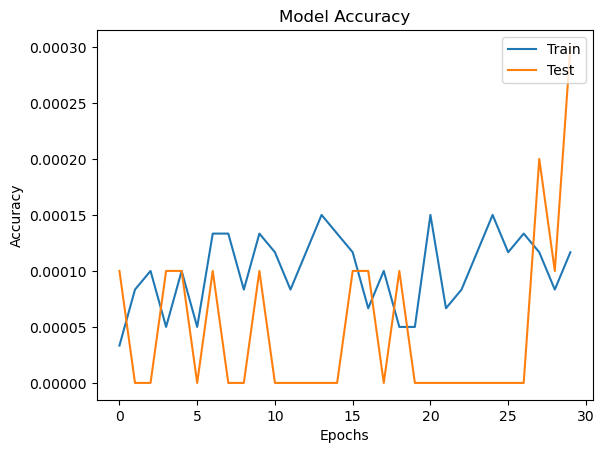

In [32]:
plt.plot(history['accuracy'])  
plt.plot(history['val_accuracy']) 
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


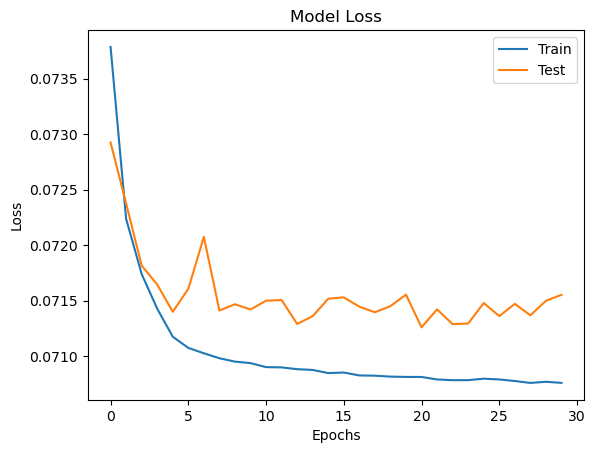

In [33]:

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()


313/313 [==============================] - 1s 2ms/step


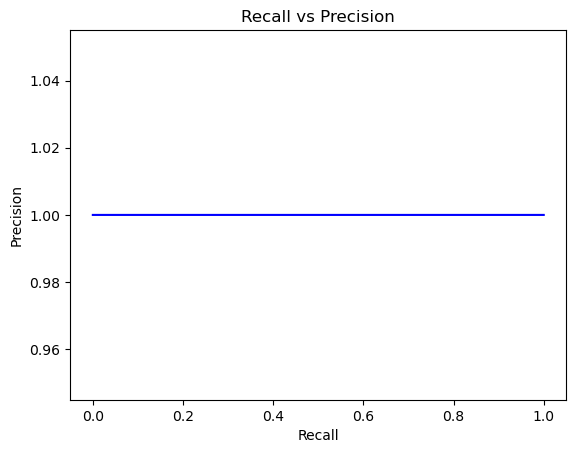

In [27]:
from sklearn.metrics import precision_recall_curve, auc, confusion_matrix

# Obtain the reconstruction error for the test set
x_test_pred = autoencoder.predict(x_test_noisy_flat)
mse = np.mean(np.square(x_test_noisy_flat - x_test_pred), axis=1)

# Get true class labels for the test set
y_test = np.ones(len(x_test_noisy_flat))  # Assuming all instances are anomalies (1)

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, mse)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()



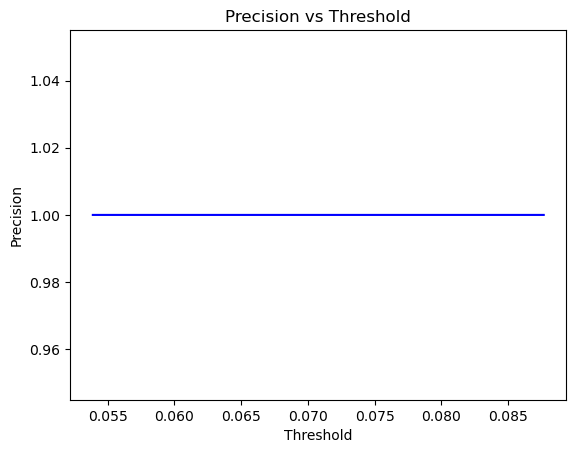

In [28]:

# Calculate precision vs threshold curve
precision, recall, thresholds = precision_recall_curve(y_test, mse)
plt.plot(thresholds, precision[:-1], 'b', label='Threshold-Precision curve')
plt.title('Precision vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()



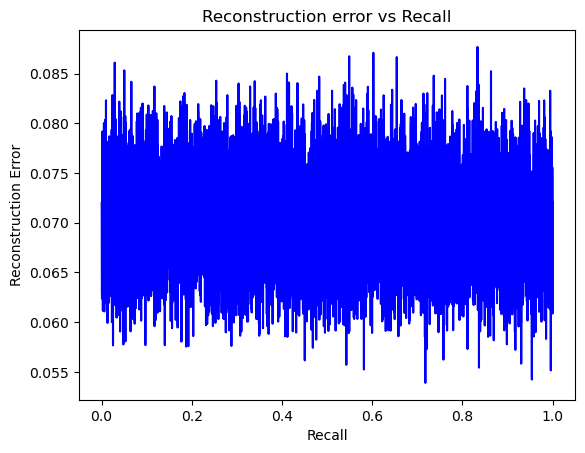

In [29]:
# Calculate reconstruction error vs recall curve
plt.plot(recall[:-1], mse, 'b', label='Reconstruction Error vs Recall curve')
plt.title('Reconstruction error vs Recall')
plt.xlabel('Recall')
plt.ylabel('Reconstruction Error')
plt.show()



Confusion Matrix:
[[    0     0]
 [10000     0]]


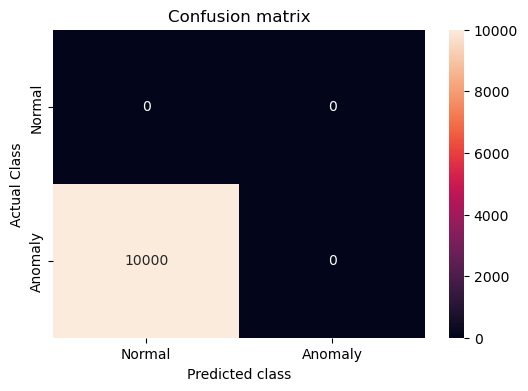

In [30]:
threshold = 2.9
ypred = [1 if e > threshold else 0 for e in mse]

# Confusion matrix
conf_matrix = confusion_matrix(y_test, ypred)
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
LABELS = ['Normal', 'Anomaly']
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted class')
plt.ylabel('Actual Class')
plt.show()

